# **Feature Engineering Notebook**

## Objectives

* Engineer features for Classification and Regression models

## Inputs

* outputs/datasets/cleaned/BTCClean.csv

## Outputs

* A dataset enhanced with newly engineered variables
* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast'

# Load Cleaned Data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/BTCClean.csv", index_col='date', parse_dates=True)
df.head()

,open,high,low,close,Volume BTC,Volume USD
date,,,,,,
2014-11-28,363.59,381.34,360.57,376.28,3220878.18,8617.15
2014-11-29,376.42,386.60,372.25,376.72,2746157.05,7245.19
2014-11-30,376.57,381.99,373.32,373.34,1145566.61,3046.33
2014-12-01,376.40,382.31,373.03,378.39,2520662.37,6660.56
2014-12-02,378.39,382.86,375.23,379.25,2593576.46,6832.53


---

# Feature Engineering

In this phase, the available features will be utilized to compute additional relevant features that are expected to enhance the performance of a model fitting to this dataset. This will involve appending new calculations to the dataframe, such as the simple moving average, volume-weighted average price, lower and upper shadows, as well as MACD.

In [5]:
import numpy as np

#Sources: 
# https://www.kaggle.com/code/oreofeolurin/hourly-btc-usd-stock-prediction-with-lstms/notebook#Feature-Engineering
# https://medium.com/@maneesh1.kumar/macd-analysis-made-easy-with-python-23fd55dab90b


def new_features(df):

    df['price mean'] = df[['open', 'high', 'low', 'close']].mean(axis = 1)
    df['upper shadow'] = df['high'] - np.maximum(df['open'], df['close'])
    df['lower shadow'] = np.minimum(df['open'], df['close']) - df['low']
    df['spread'] = df['high'] - df['low']
    df['trade'] = df['close'] - df['open']
    df['10 period SMA'] = df['close'].rolling(10).mean().fillna(0)
    df['20 period SMA'] = df['close'].rolling(20).mean().fillna(0)
    df['50 period SMA'] = df['close'].rolling(50).mean().fillna(0)
    df['100 period SMA'] = df['close'].rolling(100).mean().fillna(0)
    df['log norm close'] = np.log(df['close'] + 1)/10
    # Calculate MACD
    df['12EMA'] = df['close'].ewm(span=12, adjust=False).mean()
    df['26EMA'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12EMA'] - df['26EMA']
     # Calculate buy/sell signals
    df['buy/sell'] = df['close'].diff(periods=1)
    df = df.copy().loc[df['buy/sell'].notna()]  # Remove NaN values from diff()
    df['buy/sell'] = df['buy/sell'].apply(lambda x: 0 if x <= 0 else 1)  # 0 for sell, 1 for buy

    return df


df = new_features(df)
df.head()

,open,high,low,close,Volume BTC,Volume USD,price mean,upper shadow,lower shadow,spread,trade,10 period SMA,20 period SMA,50 period SMA,100 period SMA,log norm close,12EMA,26EMA,MACD,buy/sell
date,,,,,,,,,,,,,,,,,,,,
2014-11-29,376.42,386.60,372.25,376.72,2746157.05,7245.19,377.9975,9.88,4.17,14.35,0.30,0.0,0.0,0.0,0.0,0.593415,376.347692,376.312593,0.035100,1
2014-11-30,376.57,381.99,373.32,373.34,1145566.61,3046.33,376.3050,5.42,0.02,8.67,-3.23,0.0,0.0,0.0,0.0,0.592516,375.884970,376.092401,-0.207430,0
2014-12-01,376.40,382.31,373.03,378.39,2520662.37,6660.56,377.5325,3.92,3.37,9.28,1.99,0.0,0.0,0.0,0.0,0.593856,376.270360,376.262593,0.007766,1
2014-12-02,378.39,382.86,375.23,379.25,2593576.46,6832.53,378.9325,3.61,3.16,7.63,0.86,0.0,0.0,0.0,0.0,0.594083,376.728766,376.483883,0.244883,1
2014-12-03,379.25,383.00,374.23,376.67,2998357.92,7908.29,378.2875,3.75,2.44,8.77,-2.58,0.0,0.0,0.0,0.0,0.593402,376.719725,376.497669,0.222056,0


---

# Data Exploration

In [7]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Correlation and PPS Analysis

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [14]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%    50%    75%    max
ppscore  380.0  0.399  0.386  0.0  0.0  0.246  0.863  0.999


The PPS analysis of the new dataset shows a total of 380 feature pairs with a mean PPS score of 0.399, which is lower than the old dataset's mean of 0.446. The new dataset has more uncorrelated features (25% at 0.0), indicating a diversification in relationships.
- Will keep a Correlation Threshold of 0.4 as it still captures relatively strong relationships
- Will raise this threshold to avoid including too many weak relationships.

Display Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



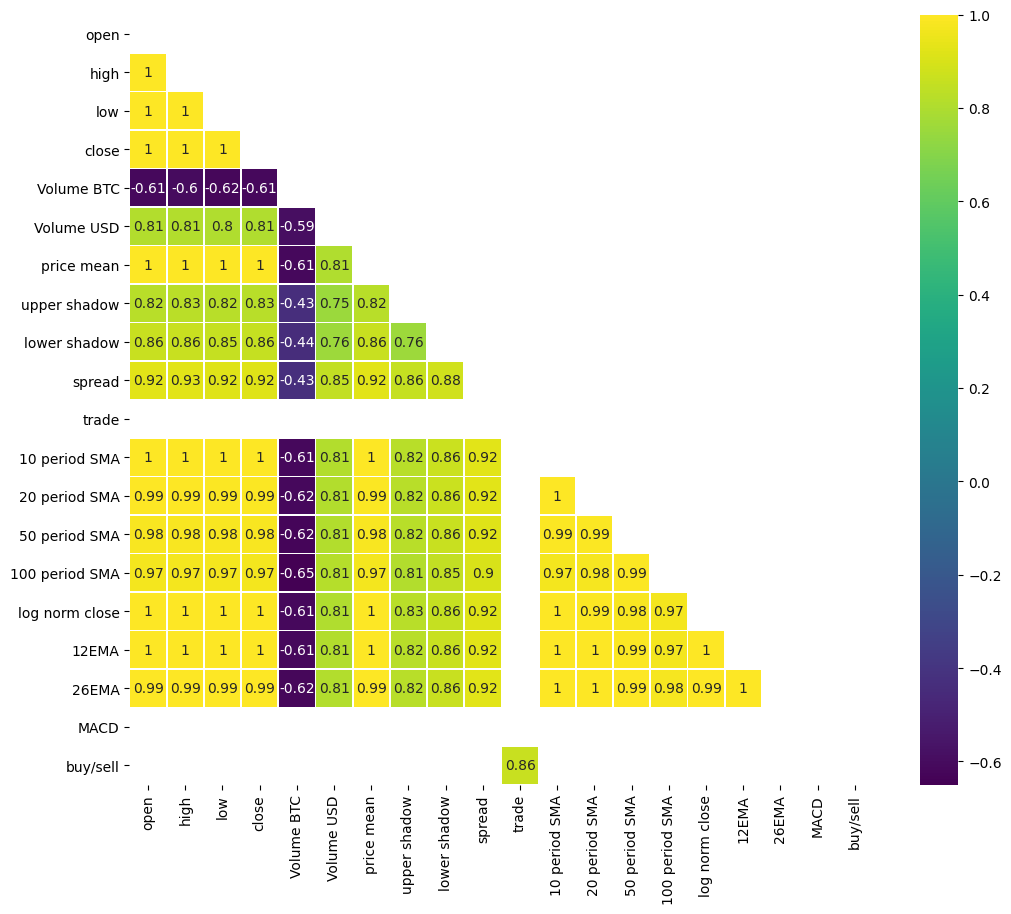



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



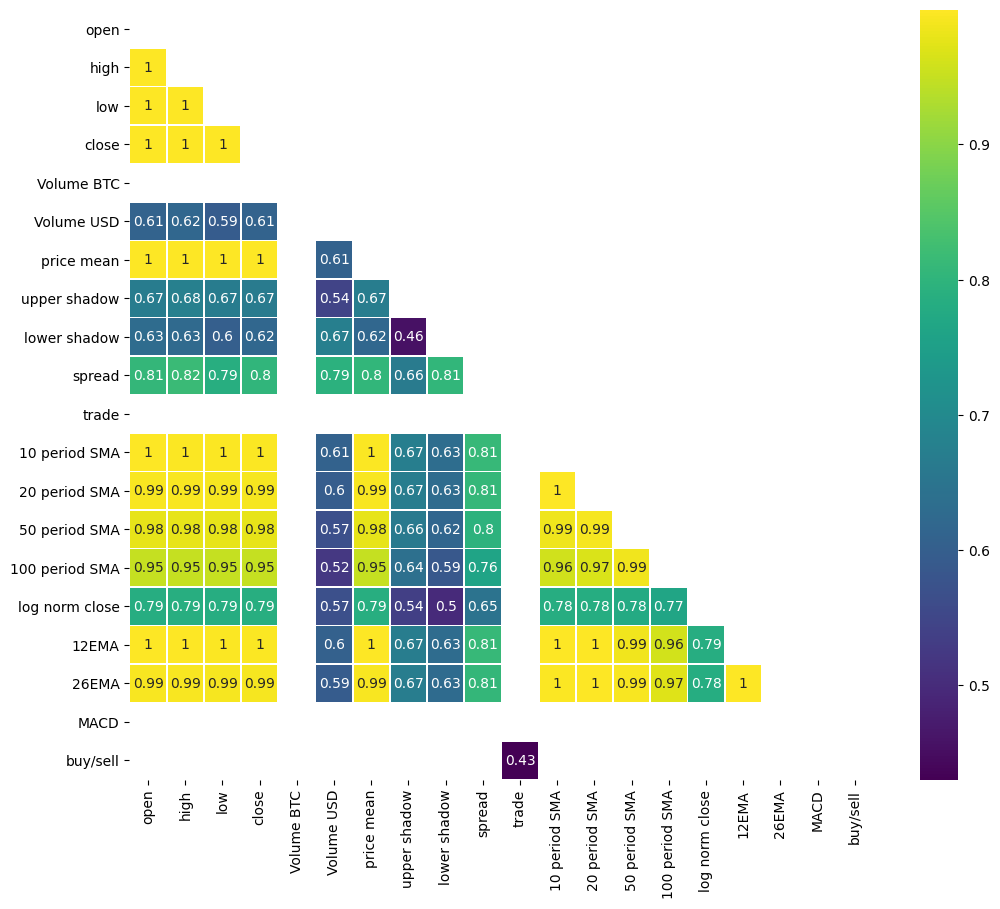



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



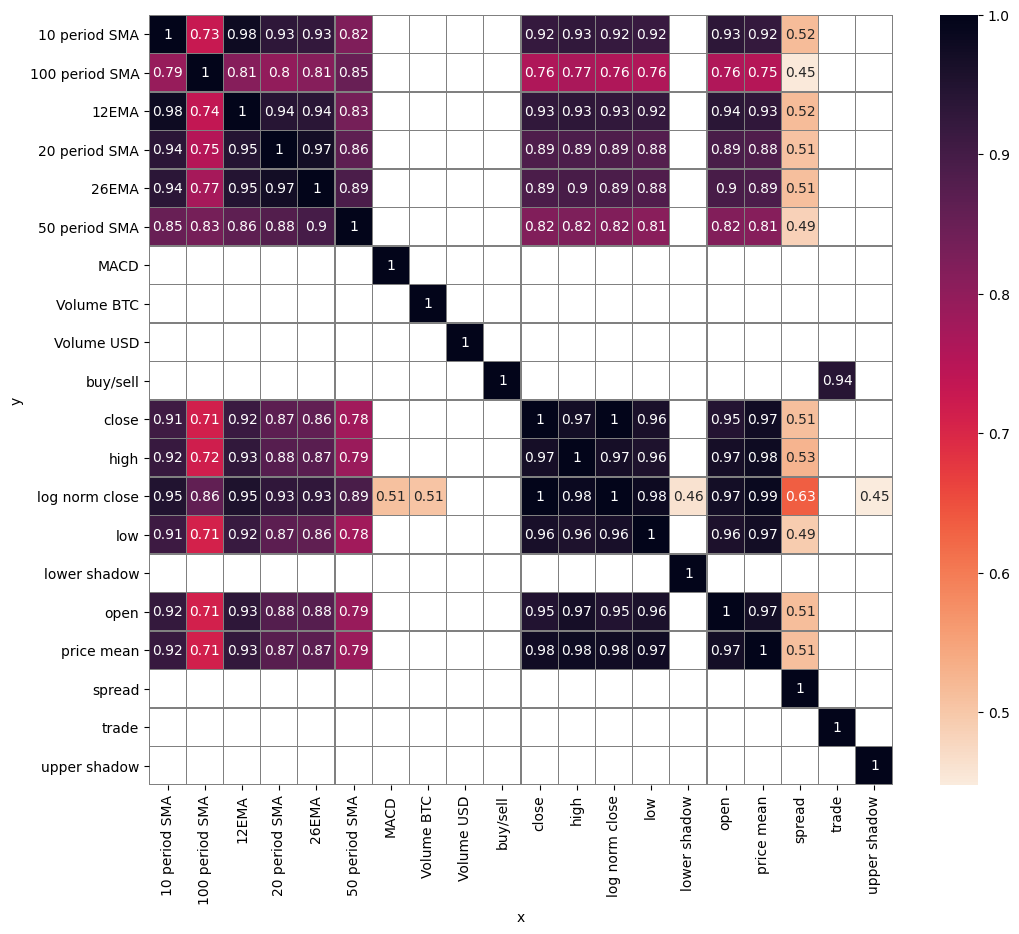

In [19]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.4,
                  figsize=(12,10), font_annot=10)

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
